## Import Libraries

In [ ]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
import os
import sys

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/AirBNBCleaned.csv')

In [ ]:
df.head(1)

,name,city,neighbourhood,zipcode,description,linear_price,property_type,room_type,accommodates,instant_bookable,...,air_conditioning,carbon_monoxide_detector,laptop_friendly_workspace,hair_dryer,kitchen,washer,dryer,kid_friendly,pool,iron
0,Beautiful brownstone 1-bedroom,NYC,Brooklyn Heights,11201,"Beautiful, sunlit brownstone 1-bedroom in the ...",0.074575,Apartment,Entire home/apt,3,0,...,1,0,0,1,1,0,1,1,0,1


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(42889, 35)

## Build a Neural Network to Predict the Review Score


For this project, I created a neural network with 4 dense layers, 3 batch normalization layers, and 3 dropout layers. The network's trained on 50 epochs with a batch size of 16 and an RMSprop optimizer to keep the performance speed high and smoothen convergence trajectories.

I've removed all rows with Nan values and split the remaining dataset (42889 rows) into training data (80%, 34311 rows) and test data (20%, 8579 rows).

In [ ]:
# Select relevant features and a target variable
X = df[['bedrooms', 'beds', 'wireless_internet', 'smoke_detector', 'air_conditioning', 'carbon_monoxide_detector', 'laptop_friendly_workspace', 'hair_dryer', 'kitchen', 'washer', 'dryer', 'kid_friendly', 'pool', 'iron', 'instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'cleaning_fee']]
Y = df['review_scores_rating']

In [ ]:
# Get the name of each city
unique_cities = df['city'].unique()

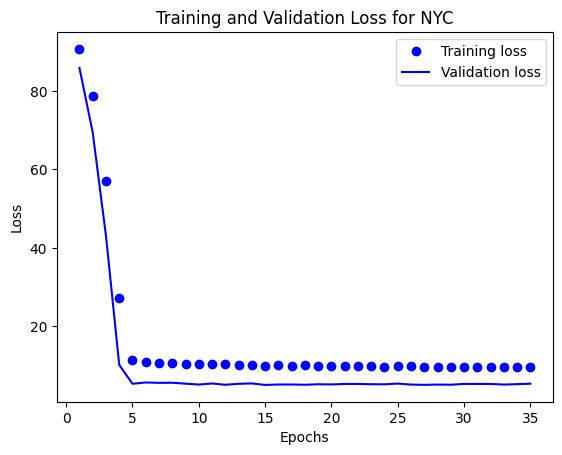

120/120 [==============================] - 1s 3ms/step
Mean Absolute Error for NYC: 5.567312240600586


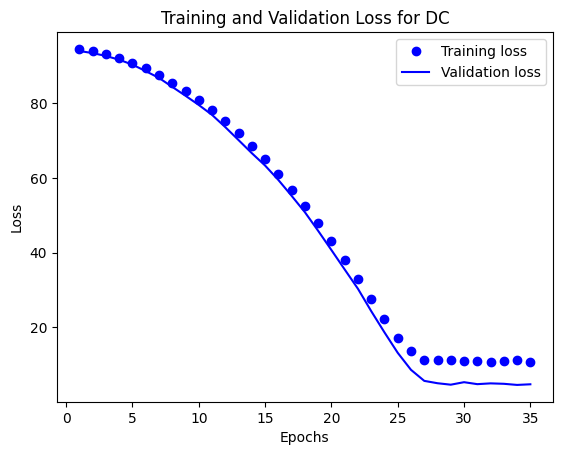

19/19 [==============================] - 0s 2ms/step
Mean Absolute Error for DC: 4.918170928955078


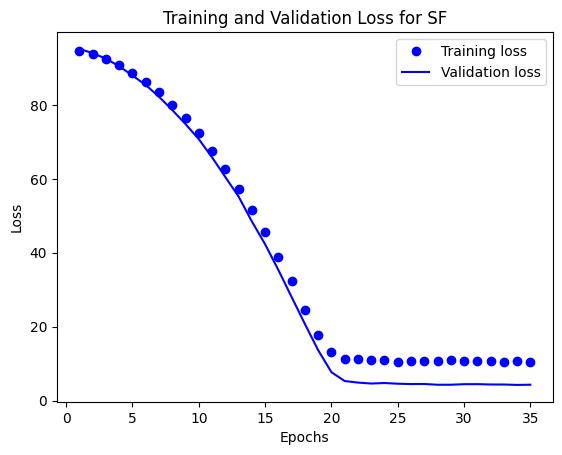

25/25 [==============================] - 0s 2ms/step
Mean Absolute Error for SF: 4.390056610107422


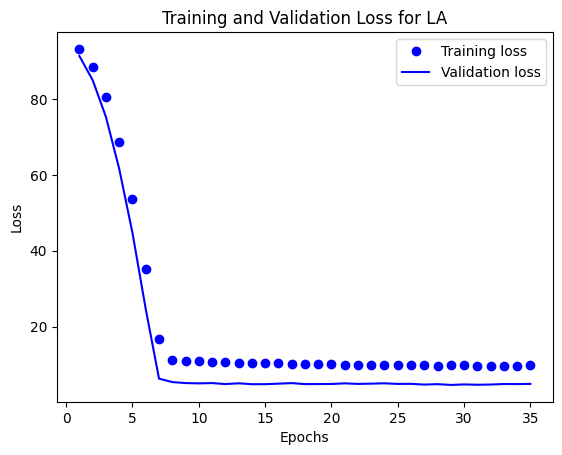

75/75 [==============================] - 0s 3ms/step
Mean Absolute Error for LA: 4.975285530090332


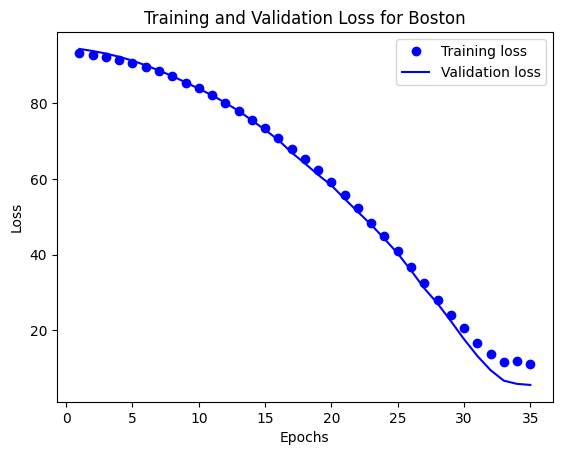

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error for Boston: 5.828528881072998


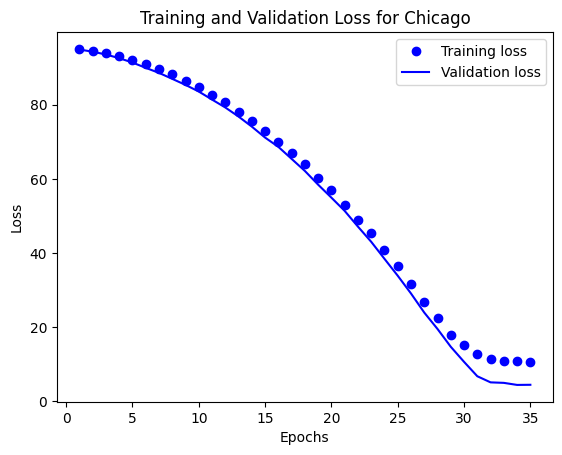

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error for Chicago: 4.7150983810424805


In [ ]:
# Build and test our neural network

# Define an empty list to store the data
mae_data = []

# Initialize lists to store training history
train_loss = []
val_loss = []

# Split the data into train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Initialize an empty list to store predictions for all cities
Y_pred_all = []

# Iterate over each city
for city in unique_cities:
    # Filter the data for the current city
    X_city_train = X_train[df['city'] == city]
    Y_city_train = Y_train[df['city'] == city]
    X_city_test = X_test[df['city'] == city]
    Y_city_test = Y_test[df['city'] == city]

    # Scale the data
    scaler_city = RobustScaler()
    X_city_train_scaled = scaler_city.fit_transform(X_city_train)
    X_city_test_scaled = scaler_city.transform(X_city_test)

    # Define and compile the model
    model_city = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_city_train_scaled.shape[1],)),

        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(32, activation='sigmoid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1)
    ])

    model_city.compile(optimizer='RMSprop', loss=tf.keras.losses.MeanAbsoluteError())

    # Train the model
    history = model_city.fit(X_city_train_scaled, Y_city_train, epochs=35, batch_size=32, validation_split=0.2, verbose=0)

    # Print training and validation loss for the current city
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'bo', label='Training loss')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {city}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Store the predictions for the current city
    Y_city_pred = model_city.predict(X_city_test_scaled)
    Y_pred_all.append(Y_city_pred)

    # Compute MAE for the current city
    mae_city = tf.keras.losses.MeanAbsoluteError()
    mae_value = mae_city(Y_city_test, Y_city_pred).numpy()
    mae_value_rounded = round(mae_value, 3)

    # Store MAE for the current city
    mae_data.append({'City': city, 'MAE': mae_value})

    # Print results
    print(f"Mean Absolute Error for {city}: {mae_value}")

# Concatenate predictions for all cities into a single array
Y_pred_all = np.concatenate(Y_pred_all)


Now we'll test how much each variable affects the predicted price in each city. To do this, I'm creating a for loop that filters the dataframe by each city and removes each variable one at a time.

In [ ]:
# Redirecting the code to a null device while I analyze the impact of each variable
original_stdout = sys.stdout
null_device = open(os.devnull, 'w')
sys.stdout = null_device

In [ ]:
# Test the effects of each variable on the review score and MAE

# Create DataFrame to store the change in MAE when each feature is removed
y_change_df = pd.DataFrame(columns=['City', 'Feature', 'Review Score Change', 'MAE Change'])

# Define the performance metric
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()

for city in unique_cities:
    cities_to_filter = ['NYC', 'SF', 'DC', 'LA', 'Boston', 'Chicago']
    X_city_train = X_train[df['city'].isin(cities_to_filter)]
    Y_city_train = Y_train[df['city'].isin(cities_to_filter)]
    X_city_test = X_test[df['city'].isin(cities_to_filter)]
    Y_city_test = Y_test[df['city'].isin(cities_to_filter)]

    original_columns = X_city_train.columns

    for feature in original_columns:
        X_train_temp = X_city_train.drop(columns=feature)
        X_test_temp = X_city_test.drop(columns=feature)

        scaler_city = RobustScaler()
        X_city_train_scaled = scaler_city.fit_transform(X_train_temp)
        X_city_test_scaled = scaler_city.transform(X_test_temp)

        model_city = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_city_train_scaled.shape[1],)),

            tf.keras.layers.Dense(128, activation='sigmoid'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(64, activation='sigmoid'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(1)
        ])

        model_city.compile(optimizer='RMSprop', loss=mean_absolute_error)

        model_city.fit(X_city_train_scaled, Y_city_train, epochs=35, batch_size=32, validation_split=0.2, verbose=0)

        Y_pred_temp = model_city.predict(X_city_test_scaled)
        mae_temp = mean_absolute_error(Y_test, Y_pred_temp).numpy()

        mae_change = mae_temp - mae_value


        # Calculate the change in the predicted price
        Y_pred_diff = Y_pred_temp - Y_pred_all

        review_score_change_scalar = np.mean(Y_pred_diff)

        y_change_df = pd.concat([y_change_df, pd.DataFrame({'City': [city], 'Feature': [feature], 'MAE Change': [mae_change], 'Review Score Change': [review_score_change_scalar]})], ignore_index=True)

y_change_df = y_change_df.sort_values(by='Review Score Change', ascending=True).reset_index(drop=True)




In [ ]:
# Closing the null device and redicting the rest of the code to the original output
sys.stdout = original_stdout
null_device.close()

In [ ]:
# Reset the index
y_change_df.reset_index(drop=True, inplace=True)

In [ ]:
# Remove text and brackets from the MAE Change column
y_change_df['MAE Change'] = y_change_df['MAE Change'].apply(lambda x: str(x) if isinstance(x, (np.float32, float)) else str(x))
y_change_df['MAE Change'] = y_change_df['MAE Change'].str.replace(r"\[.*?\]", "").str.strip()

# Convert Review Score Change column to numeric values
y_change_df['Review Score Change'] = y_change_df['Review Score Change'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
y_change_df['Review Score Change'] = pd.to_numeric(y_change_df['Review Score Change'], errors='coerce')

# Round both columns to 3 decimal places
y_change_df['MAE Change'] = y_change_df['MAE Change'].astype(float).round(3).astype(str)
y_change_df['Review Score Change'] = y_change_df['Review Score Change'].round(3)


In [ ]:
# Convert the City column to strings
y_change_df['City'] = y_change_df['City'].astype(str)

# Group by the 'City' column
grouped_df = y_change_df.groupby('City')

# Dictionary to store separated and ordered DataFrames
city_dfs = {}

# Iterate over each group
for city, group_df in grouped_df:
    sorted_df = group_df.sort_values(by='Review Score Change')
    city_dfs[city] = sorted_df

# Assign each city's rows to their own dataframe
nyc_df = city_dfs['NYC'].copy()
sf_df = city_dfs['SF'].copy()
la_df = city_dfs['LA'].copy()
dc_df = city_dfs['LA'].copy()
boston_df = city_dfs['Boston'].copy()
chicago_df = city_dfs['Chicago'].copy()



In [ ]:
# Reset the row #'s

nyc_df.reset_index(drop=True, inplace=True)
sf_df.reset_index(drop=True, inplace=True)
la_df.reset_index(drop=True, inplace=True)
dc_df.reset_index(drop=True, inplace=True)
boston_df.reset_index(drop=True, inplace=True)
chicago_df.reset_index(drop=True, inplace=True)


In [ ]:
# Print the dataframes

print("New York City")
print(nyc_df)

print("San Francisco")
print(sf_df)

print("Los Angeles")
print(la_df)

print("Washington DC")
print(dc_df)

print("Boston")
print(boston_df)

print("Chicago")
print(chicago_df)

New York City
   City                    Feature  Review Score Change MAE Change
0   NYC                   bedrooms               -0.198      0.576
1   NYC                     washer                0.073      0.441
2   NYC                 hair_dryer                0.190      0.447
3   NYC   carbon_monoxide_detector                0.255      0.392
4   NYC     host_identity_verified                0.257      0.355
5   NYC               kid_friendly                0.273      0.365
6   NYC          wireless_internet                0.322      0.371
7   NYC             smoke_detector                0.409      0.333
8   NYC       host_has_profile_pic                0.409      0.308
9   NYC           air_conditioning                0.420       0.33
10  NYC                       beds                0.496      0.286
11  NYC                      dryer                0.508      0.276
12  NYC           instant_bookable                0.530      0.265
13  NYC  laptop_friendly_workspace              